# Generalised method of moments
- The Method of Moments is a statistical technique for estimating population parameters (like means, variances, etc.) by equating sample moments (like sample means, sample variances, etc.) to their theoretical counterparts. The method is based on the law of large numbers, which states that as a sample size grows, its moments will converge to the population moments.


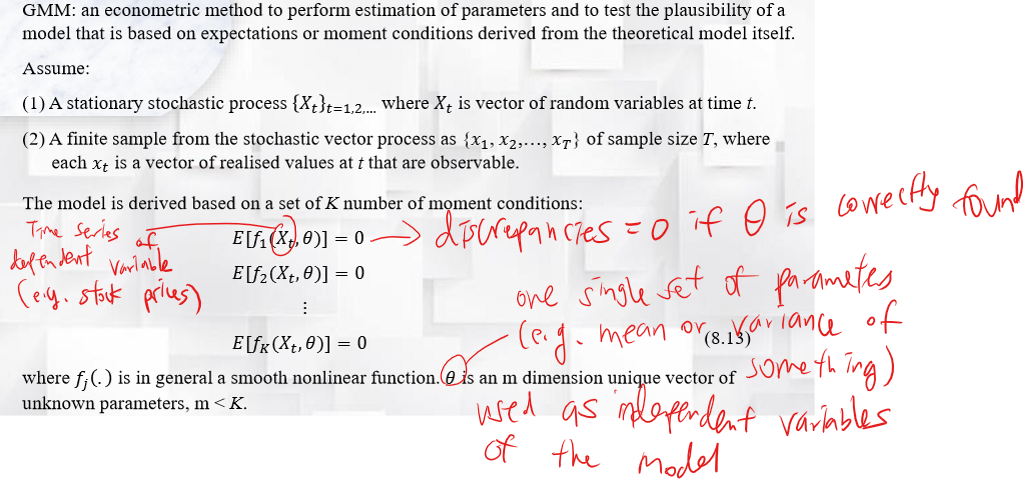
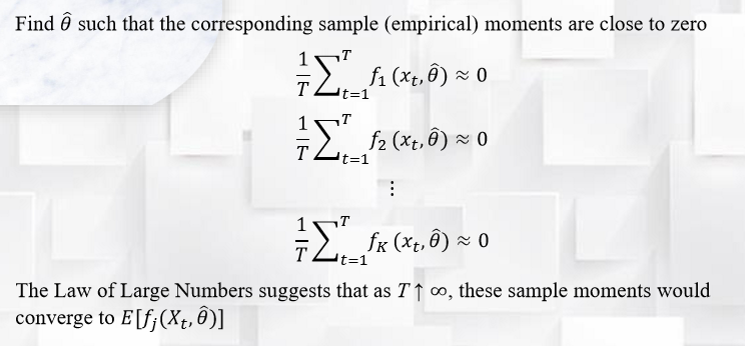
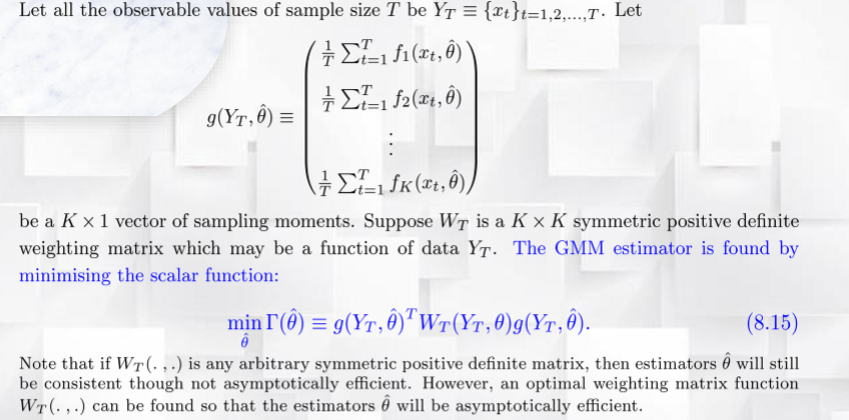

# Interest Rate Model
- predict interest rate using GMM

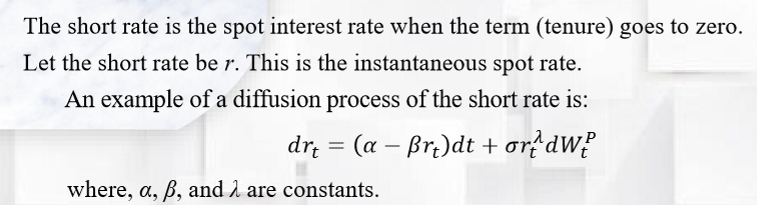

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('Interest_Rate.csv')
df

,Date,4 WEEKS BANK DISCOUNT
0,1/4/2021,0.09
1,1/5/2021,0.08
2,1/6/2021,0.09
3,1/7/2021,0.09
4,1/8/2021,0.08
...,...,...
484,12/8/2022,3.61
485,12/9/2022,3.66
486,12/12/2022,3.68
487,12/13/2022,3.71


In [3]:
DY=df['4 WEEKS BANK DISCOUNT']
# DY is annualized discount yield
# assume 4-week riskfree rates p.a. in 2021 approx the riskfree short-rate p.a.

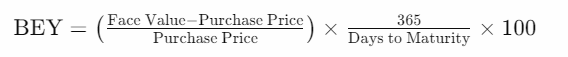
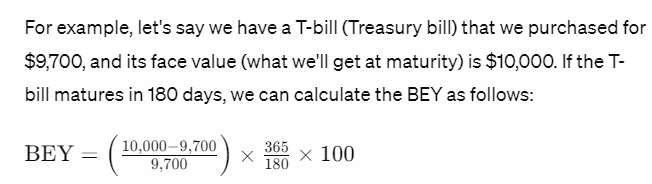

In [4]:
# convert this DY to annualized spot rate (SR) (BEY) (Bond Equivalent Yield. It is a method for determining an annual yield on a discount basis). 
# The BEY allows investors to compare the return of treasury bills (that pay no coupon interest) to other bonds that pay annual or semi-annual coupons.
SR=365*DY/(360*(1-DY/12))

In [6]:
DSR=SR.diff() 
DSR=DSR[1:489,]

SR1=SR.shift(1)
SR1=SR1[1:489,]

# independentt variable (SR1): use yesterday's SR
# dependentt variablle (DSR): change of SR from yesterday till today

# (Q) Why use GMM instead of OLS?
- OLS is used to estimate unknown paramters in a lienar regression model, and it assumes Gauss-Markov assumptions.
- Gauss-Markov assumptions assumes regressors (explanatory/ independent variables) are not correlated with the error terms. 
    - **if independent variable is correlated with error term (which means endogeneity is present), OLS estimates will become inconsistent and biased, hence need to use GMM to produce unbiased and consistent estimates of paramters**
- **Moment Conditions**: GMM is based on the idea that you can use certain "moments" (means, variances, covariances) expected to be true in the population, and create equations based on the sample that should be approximately zero if the model is correct. These are called moment conditions.

# 4-factors GMM model to estimate interest rates

# Test of interest rate models
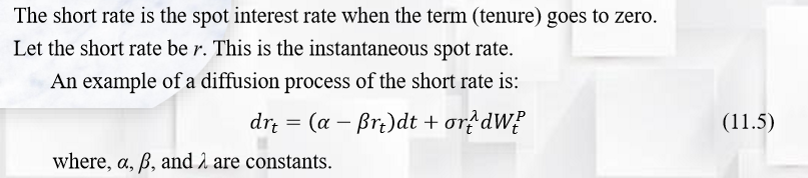
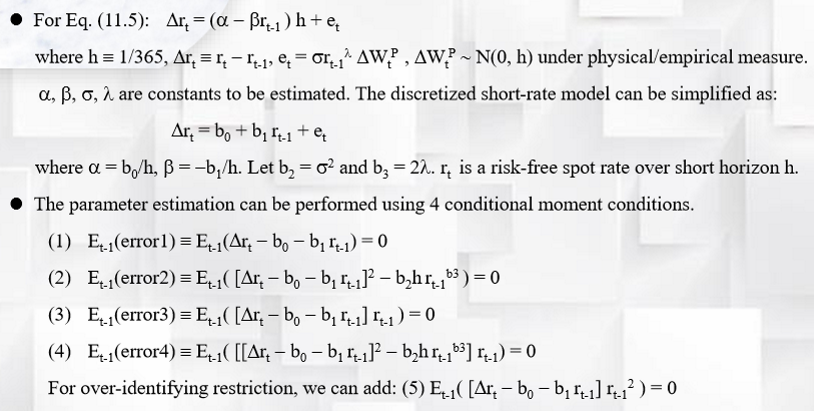

In [13]:
from statsmodels.sandbox.regression.gmm import GMM # GMM

inst = np.column_stack((np.ones(len(SR1)), SR1))

class gmm(GMM): # gmm inherits from GMM
    def momcond(self, params):
        p0, p1, p2, p3 = params 
        endog = self.endog # herits from GMM
        exog = self.exog.squeeze() # herits from GMM
        inst = self.instrument # herits from GMM   

        # observed data (y_train)
        # predicted data (y_pred) = p0 + p1 * exog
        error1 = endog - p0 - p1 * exog
        error2 = (endog - p0 - p1 * exog) ** 2 - p2 * (1/365) * (exog ** p3)
        error3 = (endog - p0 - p1 * exog) * inst[:,1]
        error4 = ((endog - p0 - p1 * exog) ** 2 - p2 * (1/365) * (exog ** p3)) * inst[:,1]
        g = np.column_stack((error1, error2, error3, error4))
        return g

initial0 = np.array([0.1, 0.1, 1, 1])
results = gmm(endog = DSR, exog = SR1, instrument = inst, k_moms=4, 
              k_params=4).fit(initial0) # .fit() is inherited from GMM

### numpy.squeeze() function is used when we want to remove single-dimensional entries from the shape of an array, e.g. [[[2,2],[3,3]]] to [[2,2],[3,3]]

print(results.summary())

Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 13
         Function evaluations: 17
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 21
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
                                   gmm Results                                   
Dep. Variable:     4 WEEKS BANK DISCOUNT   Hansen J:                    3.842e-11
Model:                               gmm   Prob (Hansen J):                   nan
Method:                              GMM                                

# 5-factors GMM model to estimate interest rates
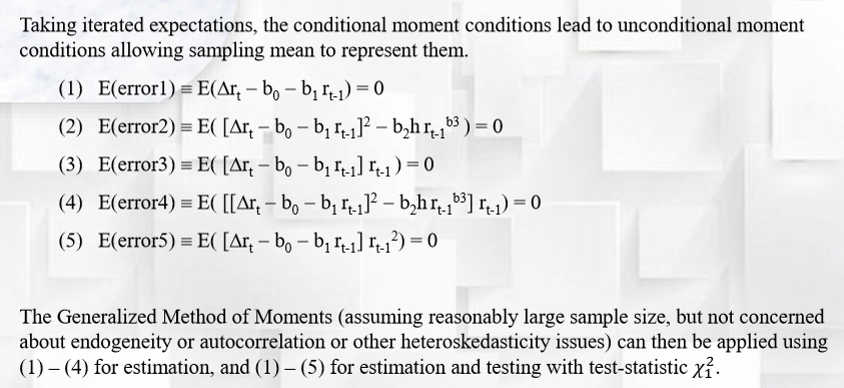

In [14]:
from statsmodels.sandbox.regression.gmm import GMM

inst = np.column_stack((np.ones(len(SR1)), SR1))

class gmm(GMM):
    def momcond(self, params):
        p0, p1, p2, p3 = params
        endog = self.endog  # delta_r_t
        exog = self.exog.squeeze() # r_t
        inst = self.instrument   

        error1 = endog - p0 - p1 * exog
        error2 = (endog - p0 - p1 * exog) ** 2 - p2 * (1/365) * (exog ** p3)
        error3 = (endog - p0 - p1 * exog) * inst[:,1]
        error4 = ((endog - p0 - p1 * exog) ** 2 - p2 * (1/365) * (exog ** p3)) * inst[:,1]
        error5 = (endog - p0 - p1 * exog) * (inst[:,1])**2
        g = np.column_stack((error1, error2, error3, error4, error5))
        return g

initial0 = np.array([0.1, 0.1, 1, 1])
results2 = gmm(endog = DSR, exog = SR1, instrument = inst, k_moms=5, k_params=4).fit(initial0)

print(results2.summary())

Optimization terminated successfully.
         Current function value: 0.000039
         Iterations: 13
         Function evaluations: 19
         Gradient evaluations: 19
Optimization terminated successfully.
         Current function value: 0.009094
         Iterations: 23
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.008856
         Iterations: 11
         Function evaluations: 16
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 0.008837
         Iterations: 14
         Function evaluations: 17
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 0.008836
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.008835
         Iterations: 6
         Function evaluations: 10
      

<font color='red'> Hansen J stats shows 4.312 with p-value 0.0379. Hence reject model at 5% significance level, but not at 1% significance level. 